In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
import datetime as dt
import seaborn as sns


%matplotlib inline

In [3]:
# let's prepare data for EDA
sbi_df = yf.download("SBIN.NS", start="2014-01-01")
sbi_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,177.199997,177.490005,176.125000,176.505005,160.800293,5904780
2014-01-02,176.589996,180.600006,173.220001,174.259995,158.755035,19451900
2014-01-03,172.699997,173.600006,171.100006,171.964996,156.664230,13759590
2014-01-06,172.190002,172.399994,168.199997,168.815002,153.794525,13907830
2014-01-07,169.289993,170.199997,165.500000,166.139999,151.357529,17352910
...,...,...,...,...,...,...
2024-03-19,730.000000,734.349976,721.150024,723.799988,723.799988,15205043
2024-03-20,725.150024,738.950012,719.799988,736.250000,736.250000,25405455
2024-03-21,742.000000,750.599976,740.549988,744.299988,744.299988,15161161


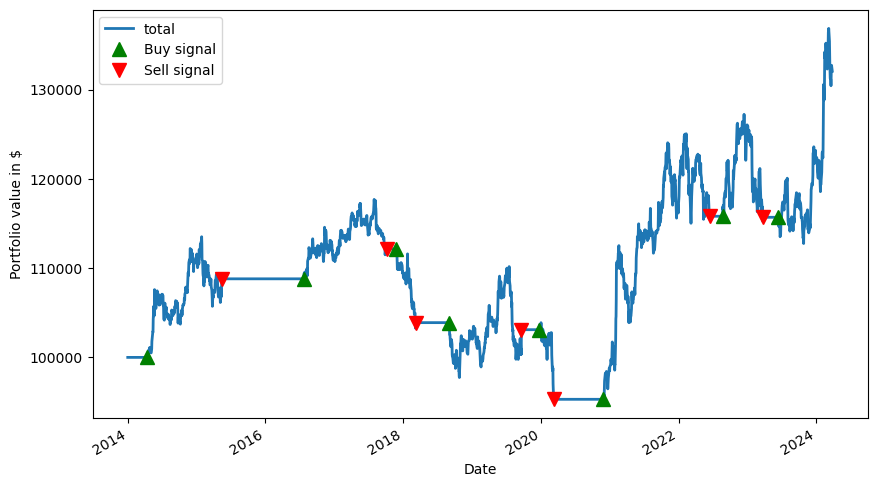

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def moving_average_crossover_strategy(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    
    # Create short and long moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    
    # Generate trading signals
    signals['signal'][short_window:] = \
        (signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:]).astype(int)
    
    # Generate buy/sell signals
    signals['positions'] = signals['signal'].diff()
    
    return signals

def backtest_strategy(data, signals):
    initial_capital = 100000.0
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions['stock'] = 100 * signals['signal']   # Buying 100 shares
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    portfolio['holdings'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    
    return portfolio

if __name__ == "__main__":
    # Load your stock data (e.g., from a CSV file)
    data = sbi_df

    # Calculate trading signals
    signals = moving_average_crossover_strategy(data)

    # Backtest the strategy
    portfolio = backtest_strategy(data, signals)

    # Plotting
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
    portfolio['total'].plot(ax=ax1, lw=2.)
    ax1.plot(portfolio.loc[signals.positions == 1.0].index,
             portfolio.total[signals.positions == 1.0],
             '^', markersize=10, color='g', lw=0, label='Buy signal')
    ax1.plot(portfolio.loc[signals.positions == -1.0].index,
             portfolio.total[signals.positions == -1.0],
             'v', markersize=10, color='r', lw=0, label='Sell signal')
    plt.legend()
    plt.show()


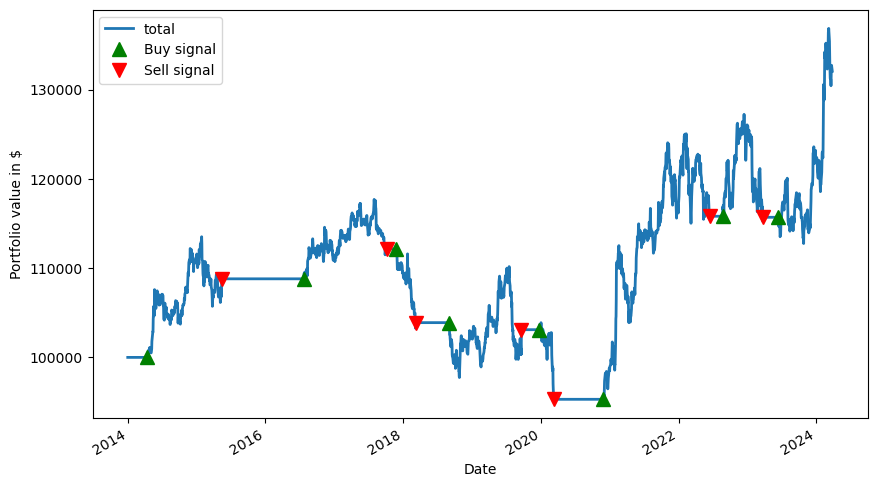

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def moving_average_crossover_strategy(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    
    # Create short and long moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    
    # Generate trading signals
    signals['signal'][short_window:] = \
        (signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:]).astype(int)
    
    # Generate buy/sell signals
    signals['positions'] = signals['signal'].diff()
    
    return signals

def backtest_strategy(data, signals, stop_loss_pct=0.05):
    initial_capital = 100000.0
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions['stock'] = 100 * signals['signal']   # Buying 100 shares
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    portfolio['holdings'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    
    # Apply stop-loss
    for i in range(1, len(portfolio)):
        if portfolio['total'][i] < (1 - stop_loss_pct) * portfolio['total'].max():
            portfolio['stock'][i] = 0
            portfolio['cash'][i] = portfolio['total'][i]
            portfolio['total'][i] = portfolio['cash'][i]
    
    return portfolio

if __name__ == "__main__":
    # Load your stock data (e.g., from a CSV file)
    data = sbi_df

    # Calculate trading signals
    signals = moving_average_crossover_strategy(data)

    # Backtest the strategy
    portfolio = backtest_strategy(data, signals, stop_loss_pct=0.0005)

    # Plotting
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111, ylabel='Portfolio value in ')
    portfolio['total'].plot(ax=ax1, lw=2.)
    ax1.plot(portfolio.loc[signals.positions == 1.0].index,
             portfolio.total[signals.positions == 1.0],
             '^', markersize=10, color='g', lw=0, label='Buy signal')
    ax1.plot(portfolio.loc[signals.positions == -1.0].index,
             portfolio.total[signals.positions == -1.0],
             'v', markersize=10, color='r', lw=0, label='Sell signal')
    plt.legend()
    plt.show()
